In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import utils.sine_dataset as sine_dat
# from utils.auxfunctions import moving_window
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hidden_dim = 20
n_signals = 1
N = 64
tagset_size = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [3]:
class LSTM_freq(nn.Module):
    """Some Information about LSTM_freq"""
    def __init__(self, N, hidden_dim, tagset_size):
        super(LSTM_freq, self).__init__()
        self.lstm = nn.LSTM(N, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        
        

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # print(f"LSTM output: {lstm_out.shape}")
        # fc_layer = self.fc(lstm_out[:,-1,:])
        fc_layer = self.fc(lstm_out[:,-1,:])
        # print(f" fc_layer: {fc_layer.shape}")
        


        return torch.sigmoid(fc_layer)


In [22]:
from utils.sine_dataset import sine_phase_creator, sine_creator, gaussian_creator

fs = 3840
N = 64
m = 100
t = np.linspace(0,N/fs,N)
signals_prueba = t
target = np.array([0])
# signals_prueba, _ = sine_phase_creator(signals_prueba, target, t, fs, m, mag_i=100, mag_f=1000)
signals_prueba, _ = gaussian_creator(signals_prueba, target, N, m, scale=3)
# Create Dataset
# print(t.shape)

# for i in (np.linspace(0, 100, 10)):
#     signal = np.array(i*np.sin(2*np.pi*fs*t))
#     signals_prueba = np.vstack((signals_prueba, signal))
signals_prueba = np.expand_dims(signals_prueba, axis=2)
signals_prueba = torch.from_numpy(signals_prueba).float()
print(signals_prueba.shape)

torch.Size([17, 64, 1])


torch.Size([17, 64, 1])
tensor([[0.0298],
        [0.0188],
        [0.0416],
        [0.0228],
        [0.0515],
        [0.0338],
        [0.0535],
        [0.0218],
        [0.0209],
        [0.0246],
        [0.0282],
        [0.0240],
        [0.0646],
        [0.0214],
        [0.0249],
        [0.1010],
        [0.0200]], grad_fn=<SigmoidBackward0>)


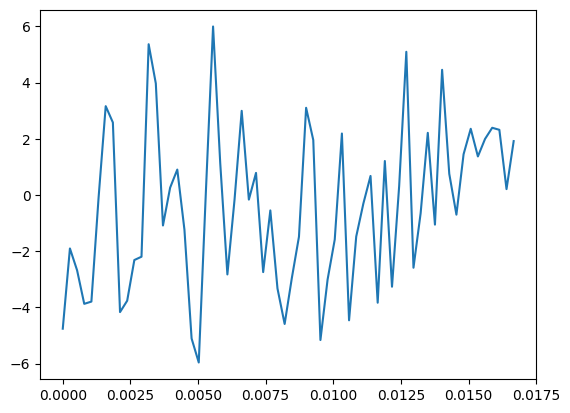

In [23]:
# torch.Size([300, 64, 1])
print(signals_prueba.shape)
x = model(signals_prueba.to(device))
plt.plot(t, signals_prueba[3,:,0])
print(x)


In [4]:
model = LSTM_freq(n_signals, hidden_dim, tagset_size).to(device)
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


In [5]:
print(f"Model structure: {model}\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:]} \n")

Model structure: LSTM_freq(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)




In [6]:
class SineWaveDataset(torch.utils.data.Dataset):
    """Some Information about SineWaveDataset
    
    signals: dim -> (m, N)

    """

    def __init__(self, signals, labels, transform=None, target_transform=None):
        super(SineWaveDataset, self).__init__()
        self.signals = signals
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, index):
        signal = self.signals[index]
        label = self.labels[index]
        if self.transform:
            signal = self.transform(signal)
        if self.target_transform:
            label = self.target_transform(label)
        # return torch.tensor(signal).float(), label
        return signal, label
    
class MockDataset(torch.utils.data.Dataset):
    """Some Information about MockDataset"""
    def __init__(self, signals):
        super(MockDataset, self).__init__()
        self.signals = signals

    def __getitem__(self, index):
        return self.signals[index]
        
    def __len__(self):
        return len(self.signals)


In [17]:

fs = 3840
N = 64
# Create Dataset


t = np.linspace(0,N/fs,N)
m = 1000
signals = t
target = np.array([[0]])

for i in (np.linspace(0.01, 100, int(m/2))):
    signal = np.array(i*np.sin(2*np.pi*fs*t))
    signals = np.vstack((signals, signal))
    target = np.vstack((target, np.array(1)))
signals = signals[:-1]
target = target[:-1]
target
for i in range(int(m/6)):
    signal = np.random.normal(scale=3, size=N)
    signals = np.vstack((signals, signal))
    target = np.vstack((target, np.array(0)))
    
for i in range(int(m/6)):
    signal = np.ones(64)*i/10
    signals = np.vstack((signals, signal))
    target = np.vstack((target, np.array(0)))

for i in range(int(m/6)):
    signal = i*t
    signals = np.vstack((signals, signal))
    target = np.vstack((target, np.array(0)))

signals = np.expand_dims(signals, axis=2)
signals = torch.from_numpy(signals).float()
target = torch.from_numpy(target).float()
print(target.shape)
print(signals.shape)


torch.Size([998, 1])
torch.Size([998, 64, 1])


In [7]:
# Dataset Parameters
fs = 3840
N = 64
m = 1000
from utils.sine_dataset import signal_dataset_creator

signals, target = signal_dataset_creator(fs, N, m)
signals = np.expand_dims(signals, axis=2)
signals = torch.from_numpy(signals).float()
target = torch.from_numpy(target).float()

In [8]:
dataset = SineWaveDataset(signals, target)
train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])
# train_dataset, test_dataset, dev_dataset  = random_split(dataset, [0.9, 0.05, 0.05])
train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=True)
# dev_dataloader = DataLoader(dev_dataset, batch_size=16, shuffle=True)






In [9]:
# Training
def train(dataloader, model, loss_fn, optimizer):
    size=len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 3 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")




In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
CUDA_LAUNCH_BLOCKING =1
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-----------------------------------
loss: 0.724127  [    0/  900]
loss: 0.579230  [   36/  900]
loss: 0.462931  [   72/  900]
loss: 0.529802  [  108/  900]
loss: 0.411963  [  144/  900]
loss: 0.617634  [  180/  900]
loss: 0.358917  [  216/  900]
loss: 0.331877  [  252/  900]
loss: 0.654475  [  288/  900]
loss: 0.212684  [  324/  900]
loss: 0.089025  [  360/  900]
loss: 0.505053  [  396/  900]
loss: 0.543295  [  432/  900]
loss: 0.145420  [  468/  900]
loss: 0.548830  [  504/  900]
loss: 0.243196  [  540/  900]
loss: 0.060146  [  576/  900]
loss: 0.055562  [  612/  900]
loss: 0.051853  [  648/  900]
loss: 0.046387  [  684/  900]
loss: 0.044972  [  720/  900]
loss: 0.198184  [  756/  900]
loss: 0.027002  [  792/  900]
loss: 0.040130  [  828/  900]
loss: 0.504616  [  864/  900]
Test Error: 
 Accuracy: 89.9%, Avg loss: 0.313835 

Done!


tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.]])
torch.Size([12, 64, 1])
tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)


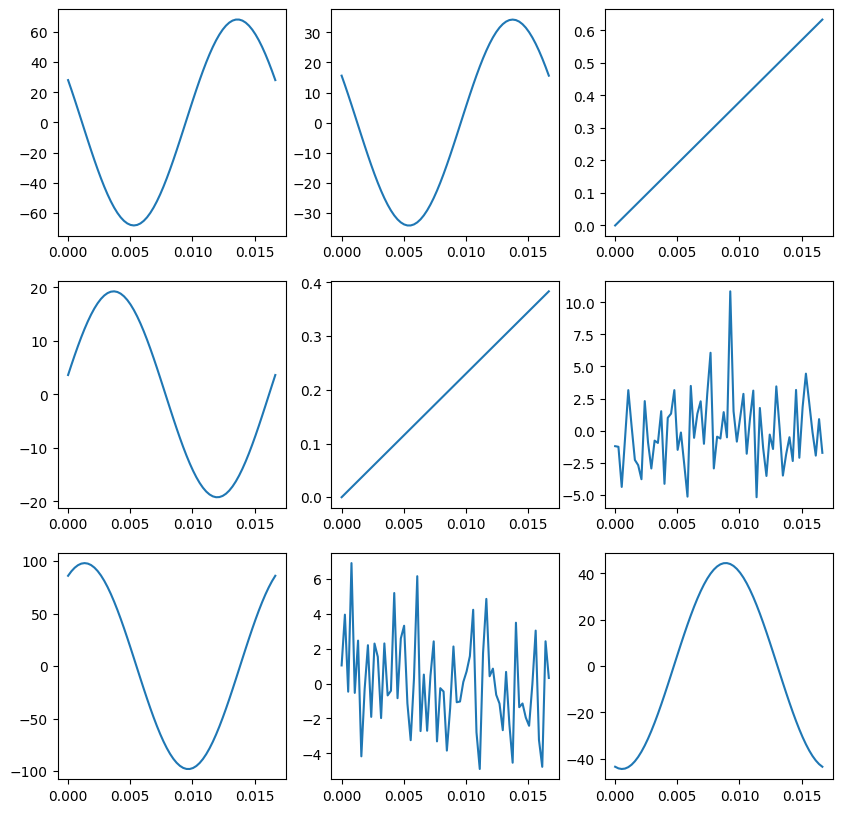

In [14]:

dataiter = iter(test_dataloader)
signal, labels = next(dataiter)

t = np.linspace(0,N/fs,N)
print(labels[1:10])
print(signal.shape)
figure = plt.figure(figsize=(10,10))
cols, rows = 3, 3
for i in range(1, cols * rows +1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t,signal[i,:,0])
x = model(signal[1:10].to(device))
print(torch.round(x))


In [53]:
CUDA_LAUNCH_BLOCKING =1
test_loss, correct = 0, 0
for batch, (x, y) in enumerate(train_dataloader):
    print(f"Batch: {batch}, label: {y[0]}")
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    correct += (torch.round(pred) == y).type(torch.float).sum().item()
    print(pred)
    print(torch.round(pred))
    print(y)
    
    
    break
print(correct)
print(loss)
# print(prob)

Batch: 0, label: tensor([1.])
LSTM output: torch.Size([16, 64, 20])
 fc_layer: torch.Size([16, 1])
tensor([[9.9763e-01],
        [1.9184e-03],
        [9.3973e-04],
        [9.9651e-01],
        [9.2341e-04],
        [9.9710e-01],
        [9.9000e-01],
        [8.0122e-04],
        [9.9748e-01],
        [3.5984e-03],
        [8.8593e-04],
        [8.2668e-04],
        [9.9770e-01],
        [3.2275e-02],
        [1.6358e-03],
        [9.9546e-01]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]], device='cu